# Load data

In [44]:
from utils import read_EHG, read_EMR
emr = read_EMR.read_EMR('dataset')
ehg = read_EHG.read_EHG('dataset')

g:\Sinh_non\utils\read_EMR.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bleeding_first_trimester']=df['Bleeding_first_trimester'].replace({'yes':1,'no':0})
g:\Sinh_non\utils\read_EMR.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bleeding_second_trimester']=df['Bleeding_second_trimester'].replace({'yes':1,'no':0})
g:\Sinh_non\utils\read_EMR.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_ob

In [45]:
import numpy as np
X_ehg = np.array(ehg[-1])
X_emr = np.array(emr[1])
y_binary = np.array(ehg[0])[:, 0]
y_regression = np.array(ehg[0])[:, 1].reshape(-1, 1)

# Utils

In [46]:
import matplotlib.pyplot as plt

def visualize(history):
    plt.figure(figsize=(20,12))
    # Accuracy
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2,2,2)
    plt.plot(history.history['precision'], label='Train Prec')
    plt.plot(history.history['val_precision'], label='Val Prec')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2,2,3)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

# Binary classification

## Split data

In [47]:
import keras

from sklearn.model_selection import train_test_split
# y_binary = keras.utils.to_categorical(y_binary, num_classes=2)

X_ehg_train, X_ehg_test, y_ehg_train, y_ehg_test = train_test_split(X_ehg, y_binary, test_size=0.2, random_state=42)
X_emr_train, X_emr_test, y_emr_train, y_emr_test = train_test_split(X_emr, y_binary, test_size=0.2, random_state=42)


from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tính trọng số cân bằng
classes = np.unique(y_ehg_train)
class_weights_array = compute_class_weight('balanced', classes=classes, y=y_ehg_train)

# Chuyển sang dict
class_weights = {i: w for i, w in zip(classes, class_weights_array)}

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_emr_train = scaler.fit_transform(X_emr_train)
X_emr_test = scaler.transform(X_emr_test)

## TCN: temporal convolution neural

In [49]:
from keras import layers, Model


class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, dilation_rate=1, dropout=0.0, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout

        # conv layers (causal padding)
        self.conv1 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.drop1 = layers.Dropout(dropout) if dropout > 0 else None

        self.conv2 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.drop2 = layers.Dropout(dropout) if dropout > 0 else None

        # residual add + final activation
        self.add_layer = layers.Add()
        self.final_act = layers.ReLU()

        # downsample will be created in build() only if needed
        self.downsample = None

    def build(self, input_shape):
        # input_shape: (batch, time, channels_in)
        channels_in = int(input_shape[-1])
        if channels_in != self.filters:
            # create 1x1 conv to match channels
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding="same", use_bias=False)
        else:
            # identity function (lambda)
            self.downsample = lambda x: x
        super().build(input_shape)

    def call(self, x, training=None):
        y = self.conv1(x)
        y = self.bn1(y, training=training)
        y = self.act1(y)
        if self.drop1 is not None:
            y = self.drop1(y, training=training)

        y = self.conv2(y)
        y = self.bn2(y, training=training)
        y = self.act2(y)
        if self.drop2 is not None:
            y = self.drop2(y, training=training)

        # residual path: downsample(x) if needed, else identity
        res = self.downsample(x)  # either a Layer or a lambda identity

        out = self.add_layer([res, y])
        return self.final_act(out)


class MultiInputModelTCN(Model):
    def __init__(self):
        super().__init__()

        # TCN branch for time series
        self.tcn1 = TCNBlock(filters=8, kernel_size=3, dilation_rate=1, dropout=0.3)
        self.tcn2 = TCNBlock(filters=16, kernel_size=3, dilation_rate=2, dropout=0.4)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.ts_dense = layers.Dense(16, activation="relu")

        # Tabular branch (MLP)
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # Combined MLP
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(1, activation="sigmoid")


    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # TCN branch
        x1 = self.tcn1(ts_input, training=training)
        x1 = self.tcn2(x1, training=training)
        x1 = self.global_pool(x1)   # -> (batch, channels)
        x1 = self.ts_dense(x1)

        # Tabular branch
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # Combine
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
    def build(self, input_shape):
        super().build(input_shape)


In [50]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, Callback

# Hàm scheduler
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.6
    return lr

# Callback để log lr mỗi epoch
# class LrLogger(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         lr_obj = self.model.optimizer.learning_rate
#         if hasattr(lr_obj, 'numpy'):
#             lr = float(lr_obj.numpy())
#         else:
#             lr = float(tf.keras.backend.get_value(lr_obj))
#         print(f"Epoch {epoch+1}: lr = {lr:.6f}")

lr_callback = LearningRateScheduler(scheduler, verbose=1)
# log_callback = LrLogger()

In [51]:
import keras
model_tcn = MultiInputModelTCN()
model_tcn.compile(optimizer= keras.optimizers.Adam(5e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", "precision", "recall"])

In [52]:
import numpy as np

# Convert class_weight dict sang sample_weight array
# sample_weights = np.array([class_weights[np.argmax(y)] for y in y_ehg_train])

history = model_tcn.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data=([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=200,
    # class_weight= class_weights,
    # callbacks=[lr_callback]
)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5984 - loss: 0.6606 - precision: 0.1628 - recall: 0.3182 - val_accuracy: 0.7812 - val_loss: 0.6325 - val_precision: 1.0000 - val_recall: 0.1250
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8189 - loss: 0.5066 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5356 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8268 - loss: 0.4601 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5334 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8268 - loss: 0.4472 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5348 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8268 - loss: 0.4409 - precision: 0.0000e+00 - recall: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Test AUC: 0.5833


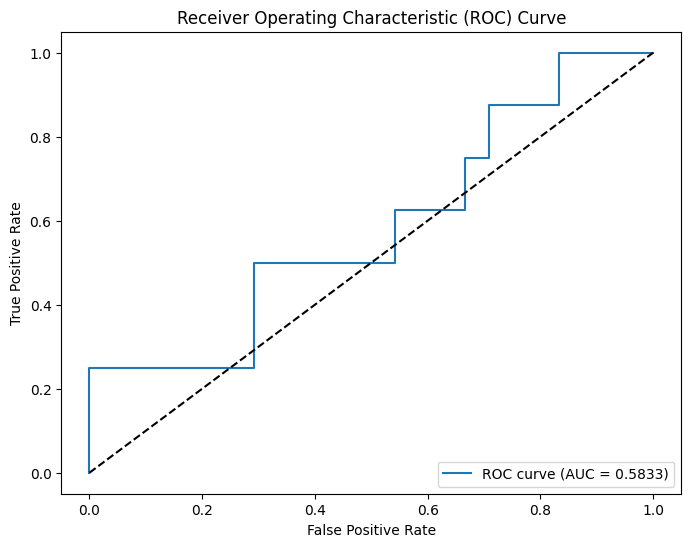

In [53]:
y_pred = model_tcn.predict([X_ehg_test, X_emr_test])
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(y_ehg_test, y_pred)
print(f"Test AUC: {auc:.4f}")

# Vẽ đường ROC
fpr, tpr, thresholds = roc_curve(y_ehg_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

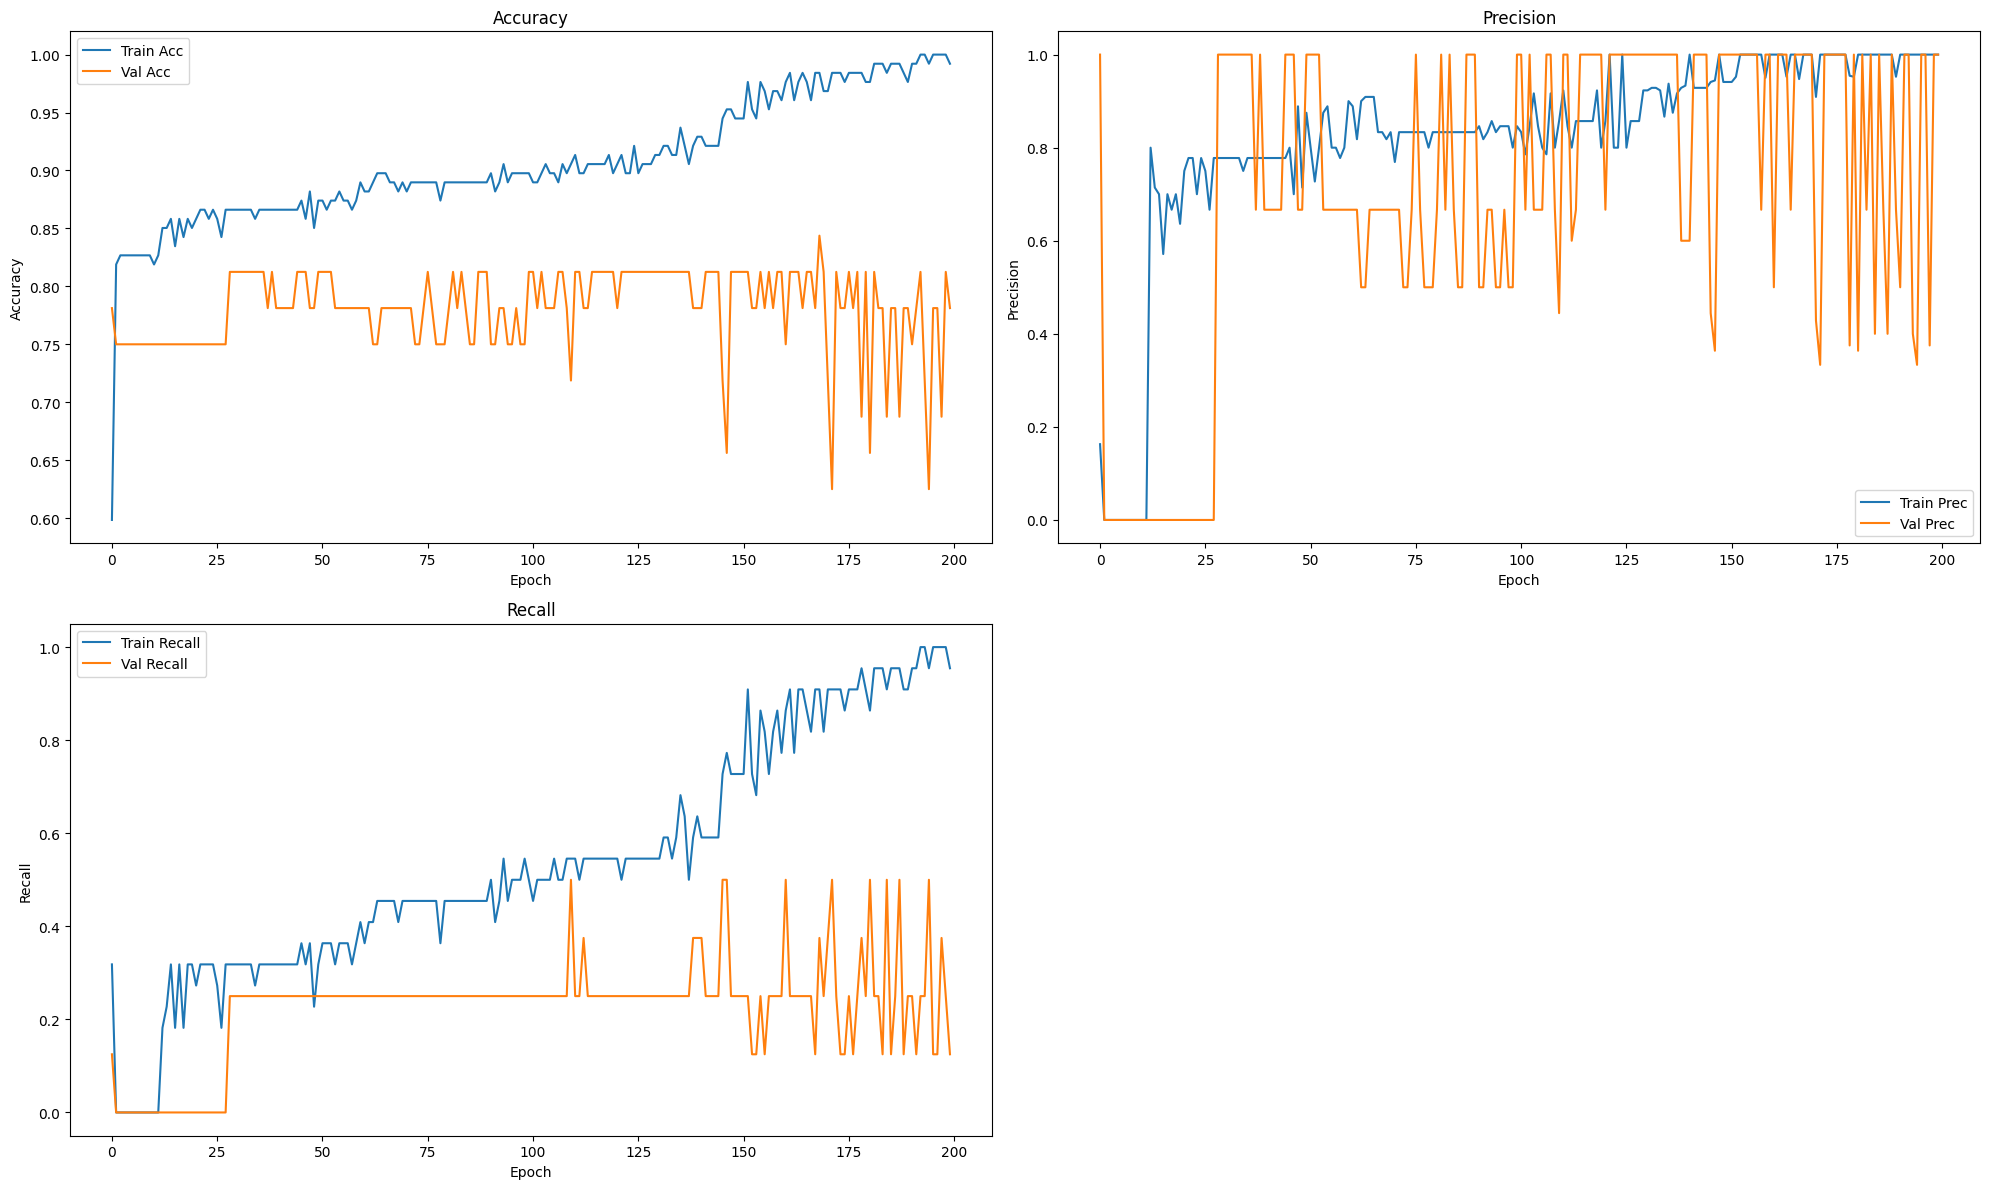

In [54]:
visualize(history= history)

## biLSTM

In [55]:
from keras import layers, Model
class BiLSTMBlock(layers.Layer):
    def __init__(self, units, dropout=0.0, return_sequences=True, name=None):
        super().__init__(name=name)
        self.units = units
        self.dropout_rate = dropout
        self.return_sequences = return_sequences

        # Bidirectional wrapper
        self.bilstm = layers.Bidirectional(
            layers.LSTM(units, dropout=dropout, return_sequences=return_sequences)
        )
        self.act = layers.ReLU()

    def call(self, x, training=None):
        y = self.bilstm(x, training=training)
        y = self.act(y)
        return y


class MultiInputModelLSTM(Model):
    def __init__(self):
        super().__init__()

        # ======== BiLSTM branch for time series ========
        self.bilstm1 = BiLSTMBlock(units=32, dropout=0.3, return_sequences=True)
        self.bilstm2 = BiLSTMBlock(units=16, dropout=0.4, return_sequences=False)
        self.ts_dense = layers.Dense(16, activation="relu")

        # ======== Tabular branch (MLP) ========
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # ======== Combined MLP ========
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(1, activation="sigmoid")

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # --- Time series branch (BiLSTM) ---
        x1 = self.bilstm1(ts_input, training=training)
        x1 = self.bilstm2(x1, training=training)
        x1 = self.ts_dense(x1)

        # --- Tabular branch ---
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # --- Combine two branches ---
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)

    def build(self, input_shape):
        super().build(input_shape)


In [56]:
model_lstm = MultiInputModelLSTM()
model_lstm.compile(optimizer= keras.optimizers.Adam(1e-2), 
              loss="binary_crossentropy", 
              metrics=["accuracy", "precision", 'recall'])

In [57]:
history = model_lstm.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    class_weight= class_weights
    # callbacks=[lr_callback]
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 626ms/step - accuracy: 0.6850 - loss: 0.6859 - precision: 0.2353 - recall: 0.3636 - val_accuracy: 0.7188 - val_loss: 0.6760 - val_precision: 0.4000 - val_recall: 0.2500
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.7717 - loss: 0.6397 - precision: 0.3871 - recall: 0.5455 - val_accuracy: 0.6562 - val_loss: 0.6844 - val_precision: 0.2857 - val_recall: 0.2500
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.7244 - loss: 0.6060 - precision: 0.3333 - recall: 0.5909 - val_accuracy: 0.6875 - val_loss: 0.6442 - val_precision: 0.3333 - val_recall: 0.2500
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.7953 - loss: 0.5657 - precision: 0.4286 - recall: 0.5455 - val_accuracy: 0.7188 - val_loss: 0.6175 - val_precision: 0.4000 - val_recall: 0.2500
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.8189 - loss: 0.5391 - precision: 0.4815 - recall: 0.5909 - val_accuracy: 0.6875 - val_loss: 0.6028

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Test AUC: 0.6042


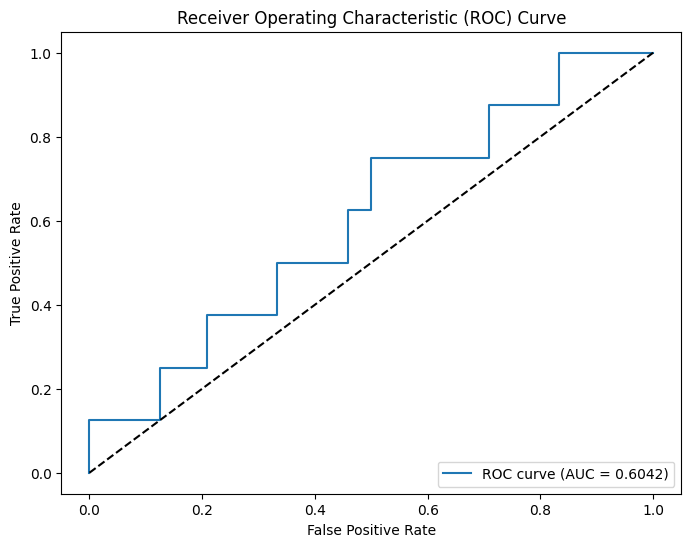

In [58]:
y_pred = model_lstm.predict([X_ehg_test, X_emr_test])
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(y_ehg_test, y_pred)
print(f"Test AUC: {auc:.4f}")

# Vẽ đường ROC
fpr, tpr, thresholds = roc_curve(y_ehg_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

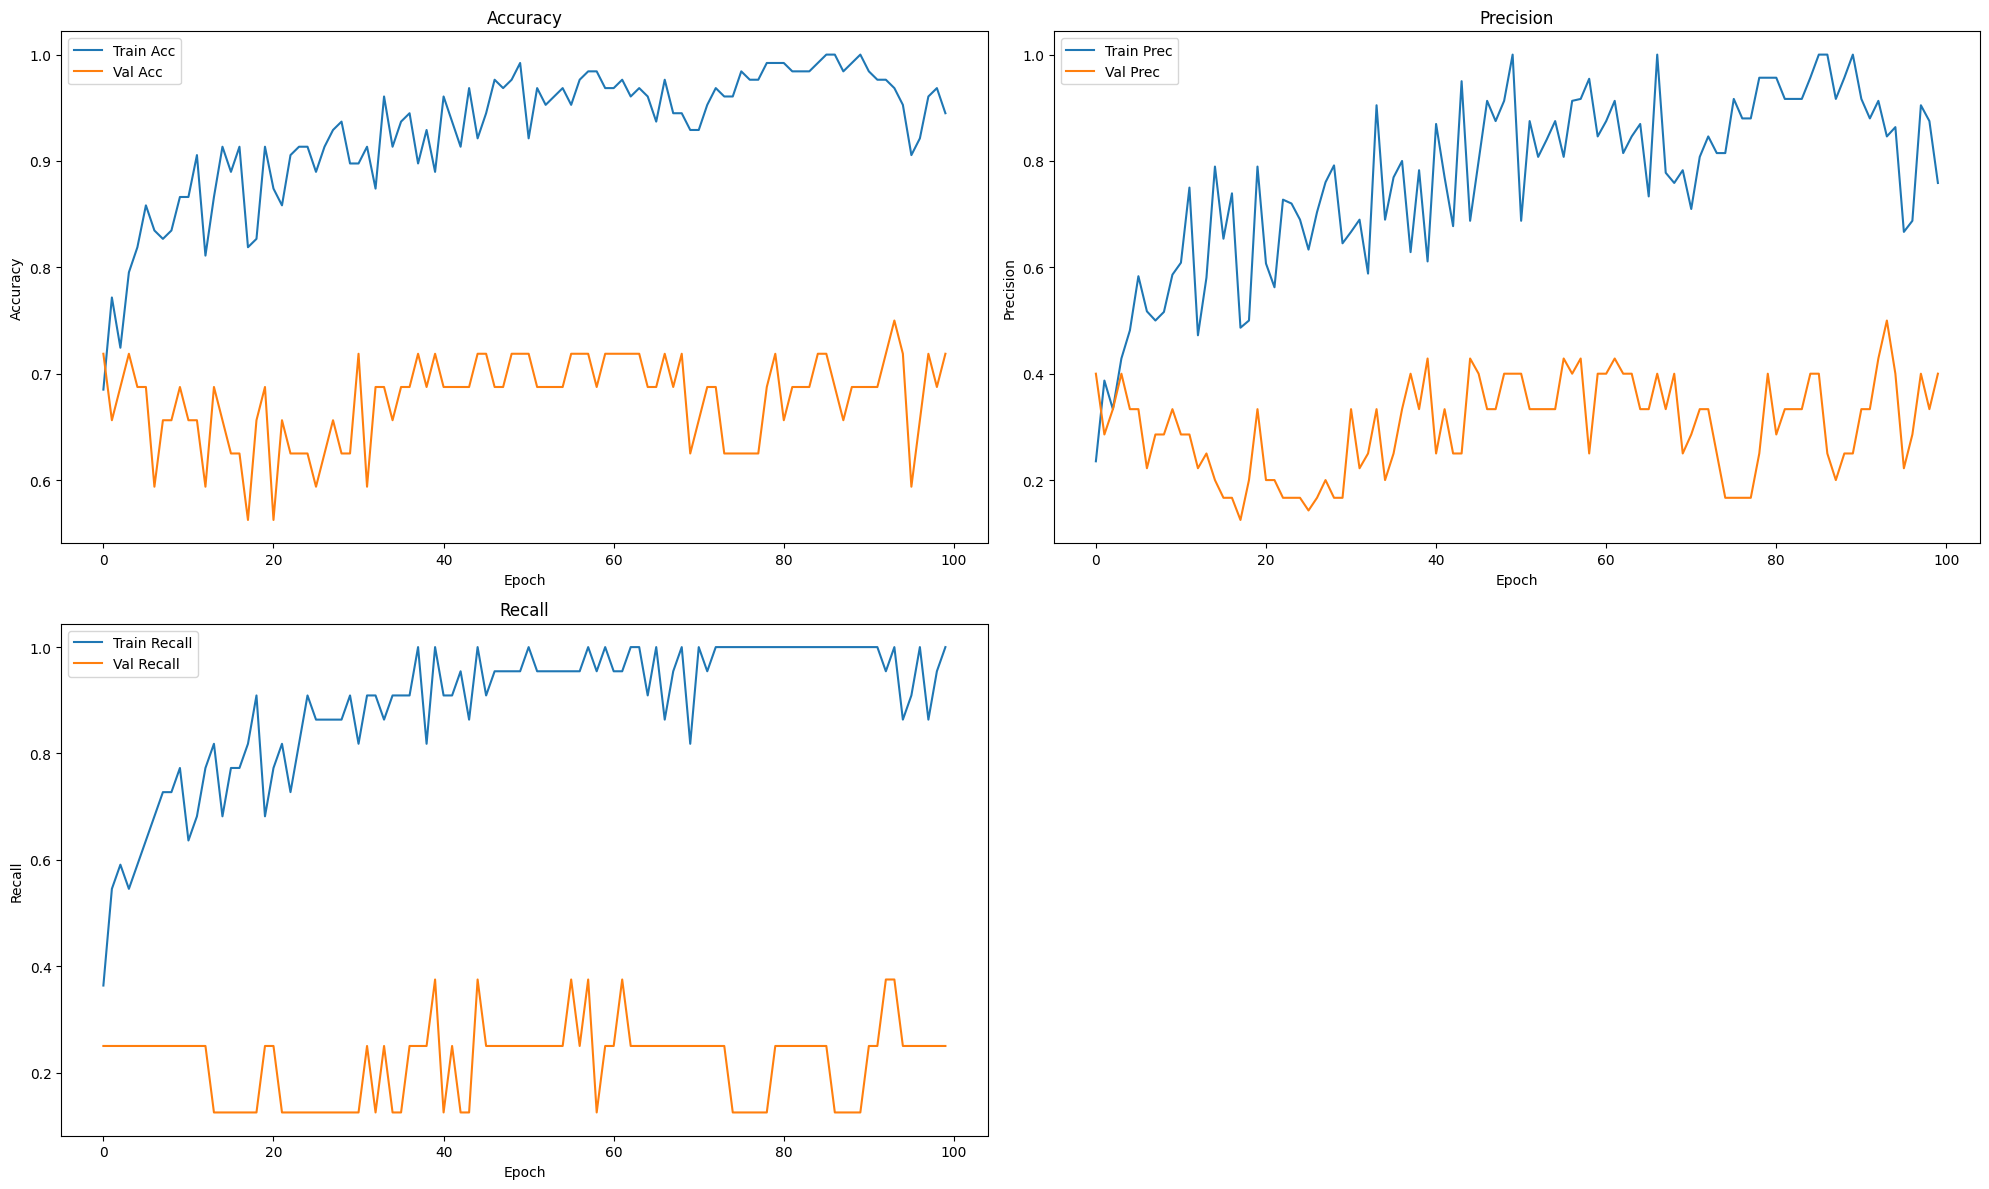

In [59]:
visualize(history= history)